<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Text_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount your Google Drive to the local /content/drive directory
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import listdir, path

local_folder = "/content/drive/My Drive/"

with open(path.join(local_folder ,"dataset/shakespeare.txt")) as f:
  shakespeare_dataset = f.read()

## Cleaning the dataset and spliting into training examples and lables

In [3]:
shakespeare_dataset = shakespeare_dataset.split('\n\n')
shakespeare_dataset = shakespeare_dataset[2:-1]

In [4]:
sos_token = "<SOS>"
eos_token = "<EOS>"
space = " "

dataset = [[sos_token + space + document ] for document in shakespeare_dataset if document != ""]
labels = [[document + space + eos_token] for document in shakespeare_dataset if document != ""]

number_documents = len(dataset)
print(number_documents)

141


In [5]:
max_doc_length = 0

for doc in dataset:
  if len(doc[0].split()) > max_doc_length:

    max_doc_length = len(doc[0].split())

print(max_doc_length)

238


## Split dataset into a training an validation set

In [7]:
training_percentage = 80

training_samples = (number_documents * training_percentage) // 100
validation_samples = number_documents - training_samples

X_train = dataset[:training_samples]
Y_train = labels[:training_samples]

X_val = dataset[training_samples:]
Y_val = labels[training_samples:]

## Text Vectorization

In [10]:
from tensorflow.keras import layers
text_vectorization = layers.TextVectorization(
    standardize='lower',
    split='whitespace',
    output_mode='int',
    output_sequence_length = max_doc_length
)

In [11]:
text_vectorization.adapt(dataset)

In [12]:
dataset = text_vectorization(dataset)
vocabulary_size = text_vectorization.vocabulary_size()
vocabulary = text_vectorization.get_vocabulary()

In [13]:
# Dictionay to map back from integer index to word
from_int_to_word ={}
from_word_to_int = {}

for idx,word in enumerate(vocabulary):
    from_int_to_word[idx] = word
    from_word_to_int[word] = idx

In [14]:
labels = text_vectorization(labels)

In [15]:
X_train = text_vectorization(X_train)
Y_train = text_vectorization(Y_train)
X_val = text_vectorization(X_val)
Y_val = text_vectorization(Y_val)

## Creation of a tensorflow dataset using training examples and labels

In [16]:
from tensorflow.data import Dataset
# Creation of the datasets to feed to the model
train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
)

val_dataset = Dataset.from_tensor_slices(
    (X_val, Y_val)
)

train_size = X_train.shape[0]

# shuffle and split into batches of batch size BATCH_SIZE
BATCH_SIZE = 64

# Buffer size of the buffer to shuffle the dataset
# Otherfwise TF will have the full dataset in memory
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Creation

In [17]:
word_embedding_vector_dimension = 16

word_embedding = layers.Embedding(
    input_dim = vocabulary_size,
    output_dim=word_embedding_vector_dimension
)

In [18]:
lstm_layer_1 = layers.LSTM(128, return_sequences = True, return_state=True)
lstm_layer_2 = layers.LSTM(128, return_sequences = True, return_state=True)

In [19]:

from tensorflow.keras.activations import softmax
softmax_layer = layers.Dense(units=vocabulary_size, activation=softmax)

In [20]:
# Because we need to output the state (which is a tensor) and the output
# then we must use the functional API
from tensorflow.keras import Input, Model

In [21]:
inputs = Input(shape=max_doc_length, batch_size = BATCH_SIZE)

embedding = word_embedding(inputs)

seq_output_1, final_memory_state_1, final_carry_state_1 = lstm_layer_1(embedding, initial_state=None)

seq_output_2, final_memory_state_2, final_carry_state_2 = lstm_layer_2(seq_output_1, initial_state=None)

outputs = softmax_layer(seq_output_2)


model = Model(inputs=inputs, outputs=outputs)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 238)]               0         
                                                                 
 embedding (Embedding)       (64, 238, 16)             68720     
                                                                 
 lstm (LSTM)                 [(64, 238, 128),          74240     
                              (64, 128),                         
                              (64, 128)]                         
                                                                 
 lstm_1 (LSTM)               [(64, 238, 128),          131584    
                              (64, 128),                         
                              (64, 128)]                         
                                                                 
 dense (Dense)               (64, 238, 4295)           554055

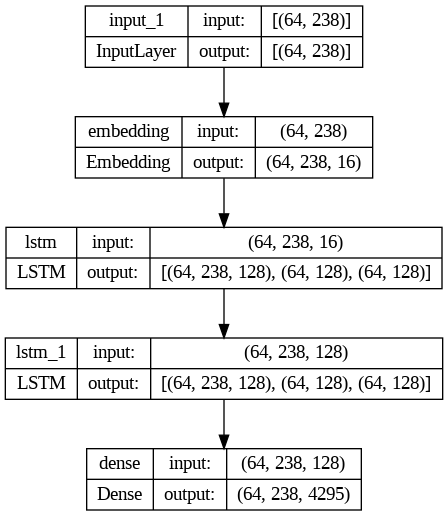

In [23]:
from keras.utils import plot_model
plot_model(model, "model_info.png", show_shapes=True)


In [24]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss = SparseCategoricalCrossentropy(from_logits=True)

In [25]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=1e-3)

In [26]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
metric = SparseCategoricalAccuracy()

In [27]:
model.compile(optimizer = adam_optimizer, loss = loss, metrics=[metric])

## Testing the model works

In [28]:
first_batch = train_dataset.take(1)

In [31]:
for input_data, labels in first_batch:
  predictions = model(input_data)
  assert predictions.shape == (BATCH_SIZE, max_doc_length, vocabulary_size)

## Configuring checkpoints

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
checkpoint_folder = path.join(local_folder,
                              "tf_checkpoints/Text Generation using RNN"
)

checkpoint_files_path = path.join(checkpoint_folder, "ckpt_{epoch}")

EPOCHS = 10
SAVING_FREQUENCY = 100

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_files_path,
    save_weights_only=True,
    #save_freq="epoch",
    #period=SAVING_FREQUENCY

)

## Training

In [36]:
restart = False
restart_epoch = 1000

if restart:
  checkpoint_files_path = path.join(checkpoint_folder, f"ckpt_{restart_epoch}")
  model.load_weights(checkpoint_files_path)

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[checkpoint_callback]
                    )

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 5.4466 - sparse_categorical_accuracy: 0.4621

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 2s 1s/step - loss: 5.4466 - sparse_categorical_accuracy: 0.4621 - val_loss: 5.0622 - val_sparse_categorical_accuracy: 0.5097
Epoch 2/10
2/2 [==============================] - 1s 367ms/step - loss: 5.1567 - sparse_categorical_accuracy: 0.4621 - val_loss: 4.7952 - val_sparse_categorical_accuracy: 0.5097
Epoch 3/10
2/2 [==============================] - 1s 401ms/step - loss: 4.9162 - sparse_categorical_accuracy: 0.4621 - val_loss: 4.5714 - val_sparse_categorical_accuracy: 0.5097
Epoch 4/10
2/2 [==============================] - 1s 372ms/step - loss: 4.7150 - sparse_categorical_accuracy: 0.4621 - val_loss: 4.3892 - val_sparse_categorical_accuracy: 0.5097
Epoch 5/10
2/2 [==============================] - 1s 420ms/step - loss: 4.5595 - sparse_categorical_accuracy: 0.4621 - val_loss: 4.2464 - val_sparse_categorical_accuracy: 0.5097
Epoch 6/10
2/2 [==============================] - 1s 391ms/step - loss: 4.4391 - sparse_categorical_accuracy: 0.4621 - val_l

## Plotting Validation and training Loss

In [37]:
import pandas as pd
results = pd.DataFrame.from_dict(history.history)

<Axes: >

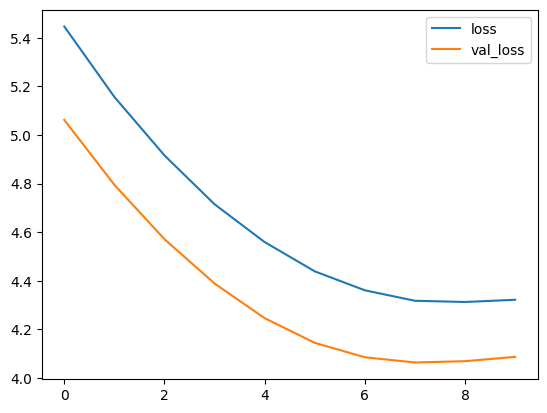

In [38]:
results.plot(y=['loss', 'val_loss'], use_index=True)

## Sampling

In [58]:
from_word_to_int["<sos>"]

18

In [59]:
char = [["<sos>"]]
char = text_vectorization(char)
test = model.predict(char)

1/1 [==============================] - 1s 863ms/step


In [60]:
test.shape

(1, 1, 4295)